# Assignment - Collaborative filtering on the Movielens dataset using SoftImpute

In [1]:
library('Matrix')
library('dslabs')
suppressMessages(library('softImpute'))

## Loading and preprocessing of the dataset

For this assignment, we will use the ```movielens``` collaborative filtering dataset. Collaborative filtering is a technique used by recommender systems, as a method of making automatic predictions about the interests of a user by collecting preferences or taste information from many users. The dataset ```movielens``` regroups $99 997$ ratings given by $671$ users to $8831$ movies. We first load the data and remove any missing values. We then create a vector of user IDs, a vector of movie titles, a vector of movie IDs, and a vector of all observed ratings that we center.

In [2]:
data("movielens")
movielens = na.omit(movielens)

users = movielens$userId; cat('Number of users: ', length(unique(users)))
movies_titles = as.factor(movielens$title) 
movies_IDs = as.numeric(movies_titles) ; cat('\nNumber of movies: ', length(unique(movies_IDs)))
ratings  = movielens$rating ; cat('\nNumber of ratings: ', length(ratings))
centered_ratings  = (ratings - mean(ratings)) 

Number of users:  671
Number of movies:  8831
Number of ratings:  99997

In collaborative filtering, the matrices are generally huge but very sparse. For example in this case, the rating matrix will be of size $671 \times 8831$, with only $99 997$ non zero elements (in theory, if we don't take into account the duplicates, etc.). As it is much easier to work with a matrix in sparse format, we will use the ```Incomplete``` function from the ```softImpute``` package to build the ratings matrix ```X```. 

In [3]:
X = Incomplete(i= users, j = movies_IDs, x = centered_ratings)
cat('Size of the matrix X: ', dim(X)[1], 'x', dim(X)[2])

Size of the matrix X:  671 x 8831

We would like to impute the missing values of ```X``` using several different methods, and compare the results.

## Preparation of the train and test sets

To be able to asses the quality of the different imputation schemes we want to test, we need to train-test split our data. The idea is to sample random elements of the ratings matrix ```X``` that we remove from ```X``` and set aside for the test in a vector. We will then apply imputation methods on the incomplete ratings matrix, and compare the values corresponding to the elements we removed with their real values.

More precisely, we begin by storing in an array the positions of the non null elements of the matrix ```X```. 

In [4]:
pos = which(X != 0, arr.ind = TRUE)
cat('Size of the position matrix: ',dim(pos)[1], 'x', dim(pos)[2])

Size of the position matrix:  99678 x 2

We then randomly select $10$% of these positions as the test elements, and we define a vector ```X_test_gt``` where we store the ground truth values of these elements.

In [5]:
n = dim(pos)[1]
ind_test = sample(n, floor(n*0.1))
pos_test = pos[ind_test,]
cat('Number of elements kept for the test : ', dim(pos_test)[1])
X_test_gt = X[pos_test]
cat('\nSize of X_test : ',length(X_test_gt))

Number of elements kept for the test :  9967
Size of X_test :  9967

Finally we define the ```X_train``` matrix, corresponding to the original ratings matrix ```X``` from which we remove the elements we selected for testing. 

In [6]:
X_train = as.matrix(X)
X_train[pos_test] = NA
X_train = as(X_train, 'Incomplete')
cat('Number of non zero elements in X :', length(which(X != 0)))
cat('\nNumber of non zero elements in X_train :', length(which(X_train != 0)))

Number of non zero elements in X : 99678
Number of non zero elements in X_train : 89711

## Collaborative filtering using constant values

We can define the problem of collaborative filtering as follows, we partly observe an user-product matrix $X \in \mathbb{R}^{n\times d}$ where we only know the values of $x_{i,j}$ for a certain set of indices $\Omega$. Although, we assume there exist an unknown matrix $Z \in \mathbb{R}^{n \times d}$ which is the "true" user-product matrix that we want to recover given our observations. We therefore have 

$$\forall (i,j) \in \Omega, x_{i,j} \approx z_{i,j}.$$

The goal in collaborative filtering is to model $x_{i,j} \approx z_{i,j}$ in a way such that $(x_{i,j}-z_{i,j})^2$ is minimized. To be able to solve this problem we need to assume that $Z$ has some simple structure. We propose to first try to model the problem using constant values.

### Average rating

A first example of simple structure is a constant matrix where all entries are identical. In a collaborative filtering context, it means all users have the exact same taste, and all products are equivalent. For our task, we propose to impute all the missing values of ```X_train``` using the average rating of the dataset. 

In [7]:
mean_rating = mean(ratings)
cat('The average observed rating is ', round(mean_rating, 3), 'out of 5')

The average observed rating is  3.544 out of 5

As we centered the data previously, imputing the missing values with the mean ratings is equivalent to giving the value $0$ to all the empty elements of ```X_train```. As we are mainly interested in the value of the Mean Squared Error for comparison purposes, we just create a vector ```X_test_cst``` of zeros instead of imputing the whole matrix. We then compute the MSE between ```X_test_gt``` and ```X_test_cst```, given by 

$$\frac{1}{m}\sum_{i=1}^m (x_i - \hat{x}_i)^2$$

where $m$ is the size of the test subset, $x_i$ is the $i$-th element of ```X_test_gt``` and $\hat{x}_i$ is the $i$-th element of ```X_test_cst```. 

In [8]:
X_test_cst = rep(0, length(X_test_gt))
mse_cst = mean((X_test_cst - X_test_gt)**2)
cat('Mean Squared Error using Constant Imputation ', round(mse_cst, 3))

Mean Squared Error using Constant Imputation  1.135

### Average rating per user

In a second example, we assume that all rows are the same. In reality, we try to impute the missing values of ```X_train``` using a constant per row. More precisely, we compute the average rating given by an user $k$, and replace all the missing values of the $k$-th row of the ratings matrix with this value. In the context of collaborative filtering, this means we assume that all products are equivalent to each user. 

In [9]:
X_avg = as.matrix(X_train)
na_ind = which(is.na(X_avg), arr.ind=TRUE)

X_avg[na_ind] = rowMeans(X_avg,  na.rm = TRUE)[na_ind[,1]]
X_test_avg = X_avg[pos_test]

Once we imputed the matrix ```X_train```, we gather the values corresponding to the test elements in a vector ```X_test_avg``` and we once again compute the MSE between ```X_test_gt``` and ```X_test_avg```.

In [10]:
mse_avg = mean((X_test_avg - X_test_gt)**2)
cat('Mean Squared Error using Average Rating per User ', round(mse_avg, 3))

Mean Squared Error using Average Rating per User  0.933

We can already see we have better results when using the average rating per using rather than the global average rating.

## Collaborative filtering using SoftImpute

A way to generalize and well-pose to previous problem is to assume that the "true" ratings matrix should have a low rank. This makes sense because it means that there are just a few factors of variation. We can recover from this the following solution

$$ \hat{Z} = \underset{Z \in \mathbb{R}^{n \times d}}{\operatorname{argmin}} \sum_{(i,j) \in \Omega} (z_{i,j} - x_{i,j})^2 + \lambda \textrm{rank}(Z)$$

The above is a hard combinatorial problem to solve due to the complexity of computing the rank of a matrix. However, as the rank of a matrix corresponds to its number of non zero singular values, it is possible to replace this number by the nuclear norm of the matrix, corresponding to the $l1$ norm of the singular values of $Z$, given by

$$ \Vert Z \Vert_* = \sum_{i=1}^{min(d,n)} \sigma_i(Z),$$

where the $\sigma_i(Z)$ are the singular values of $Z$. In reality, the nuclear norm being a convex relaxation of the rank of a matrix, it is often used in optimization tasks to search for low rank matrices, as it is easier to compute (it is given by $tr(\sqrt{Z^TZ})$ for real matrices) . This allows to re write the initial problem as 

$$ \hat{Z} = \underset{Z \in \mathbb{R}^{n \times d}}{\operatorname{argmin}} \sum_{(i,j) \in \Omega} (z_{i,j} - x_{i,j})^2 + \lambda \Vert Z \Vert_*.$$

This new problem is convex, and there exists very fast algorithms to approximate it. We will use the ```softImpute``` function to impute the missing values of ```X``` by doing nuclear norm penalized matrix completion. 

### Default hyper parameters

Let us first try with the default parameters of the function. As we did previously, we impute the missing values of ```X_train``` using the algorithm, and we then recover the elements corresponding to the test set and store them in a vector ```X_test_softimp```. We compute the MSE between ```X_test_gt``` and ```X_test_softimp``` to assess the quality of the method. 

In [11]:
res = softImpute(X_train, maxit=1000)
X_softimp = complete(X_train,res)
X_test_softimp = X_softimp[pos_test]

mse_softimp = mean((X_test_gt - X_test_softimp)**2)
cat('Mean Squared Error for Soft Impute: ', round(mse_softimp, 3))

Mean Squared Error for Soft Impute:  0.865

### Choice of hyper parameters through Cross-Validation

The ```softImpute``` already yields better results than constant imputation, but let us look at the hyper parameters of the algorithm to see if the results can be improved. We are interested in the following settings: 

#### The ```lambda``` hyper parameter
- This corresponds to the nuclear-norm regularization parameter. 
- If ```lambda=0```, the algorithm reverts to "hardImpute", for which convergence is typically slower and to local minimum.

#### The ```type``` hyper parameter 
- If ```type='svd'```, the algorithm repeatedly computes the singular value decomposition of the completed matrix, and soft thresholds its singular values. Each new soft-thresholded decomposition is used to reimpute the missing entries. 
- If ```type='als'```, the algorithm updates the imputation at each step, leading to quite substantial speedups in some cases. Although the ```'als'``` approach does not currently have the same theoretical convergence guarantees as the ```'svd'``` approach.
- In the next steps, we set ```type='svd'```.

#### The ```rank.max``` hyper parameter
- This parameter restricts the rank of the solution. 
- If sufficiently large, and with ```type='svd'```, the solution solves the nuclear-norm convex matrix-completion problem. In this case the number of nonzero singular values returned will be less than or equal to rank.max.
- If smaller ranks are used, the solution is not guaranteed to solve the problem, although still results in good local minima.

We use cross-validation to choose these hyperparameters properly. We define a range of values to be tested for ```lambda``` and ```rank.max```, we complete the ```X_train``` ratings matrix using each values in turn, gather the elements corresponding to the test set, and estimate the MSE for each value of the hyper parameters. Finally, the values selected are the ones for which the MSE is minimized. 

In [12]:
lambdas = seq(0,10,1)
ranks = seq(1, 5, 1)
errors=matrix(nrow=length(lambdas), ncol=length(ranks))

for (i in 1:length(lambdas)){
    for (j in 1:length(ranks)){
        res = softImpute(X_train, rank.max=ranks[j] ,lambda= lambdas[i], type='svd', maxit=1000)
        x_softimp = complete(X_train,res)
        x_test_softimp = x_softimp[pos_test]
        mse = mean((X_test_gt - x_test_softimp)**2)
        errors[i,j] = mse
    }
}

In [13]:
pos_min = which(errors == min(errors), arr.ind = TRUE)
mse_min = round(min(errors),5)
cat('Best Mean Squared Error for rank.max=', ranks[pos_min[2]], 'and lambda=', ranks[pos_min[2]], ':', mse_min)

Best Mean Squared Error for rank.max= 2 and lambda= 2 : 0.85767

We tested the algorithm for values of ```rank.max``` between $1$ and $5$, and ```lambda``` between $0$ and $10$. The MSE seems to be at its minimum for ```rank.max=2``` and ```lambda=2```, but we can try to see if we can find an even more precise value for ```lambda```.

In [17]:
lambdas = seq(1,3,0.25)
errors=c()

In [18]:
for (i in lambdas){
    res = softImpute(X_train, rank.max=2, lambda= i, type='svd', maxit=1000)
    x_softimp = complete(X_train,res)
    x_test_softimp = x_softimp[pos_test]
    mse = mean((X_test_gt - x_test_softimp)**2)
    errors = c(errors, mse)
}

Best Mean Squared Error for lambda= 1.25 : 0.85766

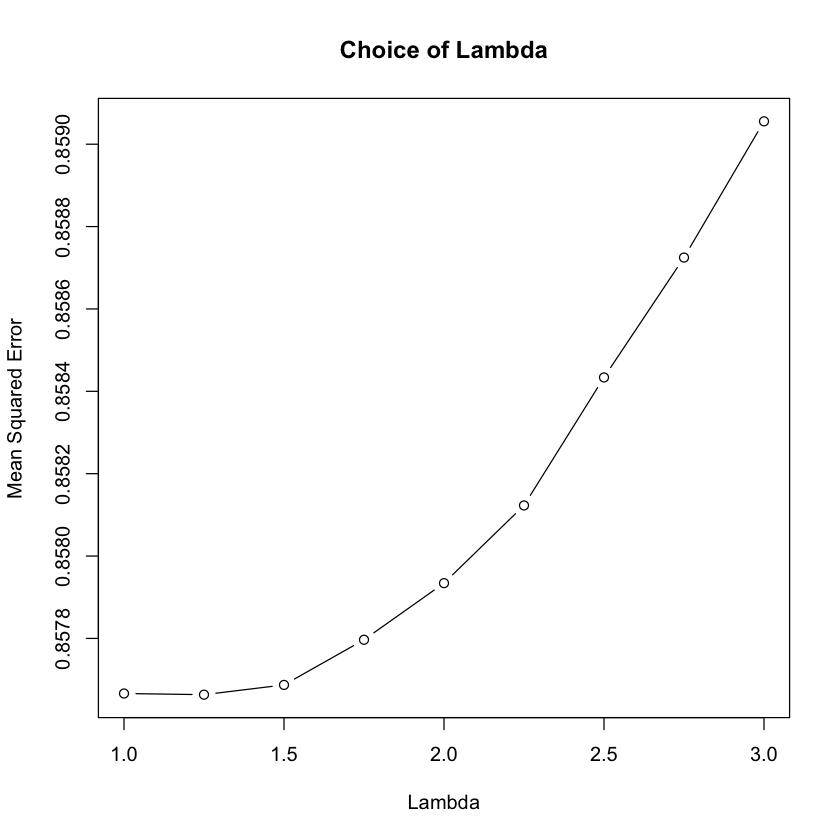

In [19]:
plot(lambdas,errors,type='b', main='Choice of Lambda', xlab='Lambda', ylab='Mean Squared Error')  
cat('Best Mean Squared Error for lambda=', lambdas[which.min(errors)], ':', round(min(errors),5))

## Conclusion

We explored the ```softImpute``` algorithm to impute the missing values of a user-product matrix by doing nuclear norm penalized matrix completion. We also implemented very simple baseline as competitors, by using constant imputations for example. We assessed the quality of the imputation schemes by defining a train set and a test set, and estimating the Mean Squared Errors of our methods.

We achieved better results by using the average ratings per user as imputation ($0.933$) rather than the global average rating ($1.135$), but we reached an even lower error with the ```softImpute``` algorithm. We finally used cross-validation to fine tune the hyperparameters of the function, and were able to achieve a MSE of $0.857$ with ```rank.max=2``` and ```lambda=1.25```.